# Meetup Project


What is in a Meetup API request?

1. https://api.meetup.com: The API host.
2. /find/groups: The method
3. zip=11211&radius=1&category=25: The args. Here is where you may add the API key.
    From what I can tell, the only args you can give are zip, radius, and category. So maybe you need to go through the zips 
4. &order=members:  How to order the results.
 
* To find last event in the list: db.events.find().limit(1).sort({$natural:-1})

ssh -L localhost:8888:localhost:8888 -i "ecdoso.pem" ec2-user@ec2-52-14-250-184.us-east-2.compute.amazonaws.com


# Imports / Pymongo Setup

In [235]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import requests
import json
import warnings
import time
import scipy.stats as scs
import scipy
from pprint import pprint
import sys
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sys.path.append('./src')
warnings.filterwarnings('ignore')
key = open('src/api.txt', 'r').read()

client = MongoClient()
db = client['meet-ups']
collection = db.groups
events_coll = db.events_two
attendees = db.attendees
categories = db.category_per_group

## Get number of groups in each category globally

In [74]:
from groups_per_category import get_count_of_category, get_ids_of_categories

ids, dict_categories = get_ids_of_categories()
groups_per_category = [get_count_of_category(dict_categories, category) for category in ids]

In [75]:
#Total number of groups

pprint(groups_per_category)
sum([val[1] for val in groups_per_category])

[[1, 7129, 'Arts & Culture'],
 [2, 51451, 'Career & Business'],
 [3, 2042, 'Cars & Motorcycles'],
 [4, 7478, 'Community & Environment'],
 [5, 4951, 'Dancing'],
 [6, 9452, 'Education & Learning'],
 [8, 1509, 'Fashion & Beauty'],
 [9, 8261, 'Fitness'],
 [10, 10133, 'Food & Drink'],
 [11, 7841, 'Games'],
 [12, 4374, 'LGBT'],
 [13, 5211, 'Movements & Politics'],
 [14, 27598, 'Health & Wellbeing'],
 [15, 4054, 'Hobbies & Crafts'],
 [16, 14186, 'Language & Ethnic Identity'],
 [17, 1488, 'Lifestyle'],
 [18, 4339, 'Book Clubs'],
 [20, 3508, 'Movies & Film'],
 [21, 7131, 'Music'],
 [22, 17421, 'New Age & Spirituality'],
 [23, 14579, 'Outdoors & Adventure'],
 [24, 407, 'Paranormal'],
 [25, 6975, 'Parents & Family'],
 [26, 2556, 'Pets & Animals'],
 [27, 3889, 'Photography'],
 [28, 6312, 'Religion & Beliefs'],
 [29, 1394, 'Sci-Fi & Fantasy'],
 [30, 2387, 'Singles'],
 [31, 23125, 'Socializing'],
 [32, 9928, 'Sports & Recreation'],
 [33, 7019, 'Support'],
 [34, 64512, 'Tech'],
 [36, 3510, 'Writing']

346150

I find 344,607 groups globally. Wow!

# Download all Meetup Groups

In [ ]:
from get_groups_for_category import * 

for number in ids:
    get_groups_for_category(number, groups_per_category)

# Visibilities

88% of the groups are public, 12% are public_limited, and 0.3% are members.

Public_limited allows you to see the events, but not who went. Members does not allow you to even see the events. 
Thus, these groups both need to be deleted.

In [118]:
def percent_each_visibility(collection):
    visibilities = collection.distinct('visibility')
    total_count = collection.count()
    percentages = [[option, round(collection.find({'visibility': option}).count() / total_count, 3) * 100] for option in visibilities]
    return percentages

#Remove these visibilities from meetups.

collection.delete_many({'visibility' : {'$in' : ['public_limited', 'members']}})

percent_each_visibility(collection)

[['public', 100.0]]

# Download the events for a particular group

In [140]:
req = requests.get('https://api.meetup.com/Florida-MUFON-UFO-Research-and-Investigations/events?\
                    key={}&status=past'.format(key))

print(req.headers['X-Total-Count'])
pprint(json.loads(req.text)[0])

168
{'created': 1351348658000,
 'date_in_series_pattern': False,
 'description': '<p>\xa0</p> <p>\xa0</p> <p>\xa0</p> <p>\xa0</p> <p>\xa0</p> '
                "<p>Our FIRST MUFON Meetup \xa0will be at <b>Mimi's "
                'Cafe</b></p> <p>at the Avenues in Viera, FL. \xa0From 5:30 pm '
                'to 8:30 pm.</p> <p>\xa0</p> <p>Please RSVP for this meeting '
                'and all future meetings.</p> <p>Feel free to bring a friend '
                'or two. See you there!</p> <p>\xa0</p> <p>Your Host for the '
                'evening will be</p> <p><b>MUFON</b> Assistant State Director '
                'Teri Lynge</p> ',
 'duration': 10800000,
 'group': {'country': 'us',
           'created': 1351346689000,
           'id': 5582872,
           'join_mode': 'open',
           'lat': 27.969999313354492,
           'localized_location': 'Palm Bay, FL',
           'lon': -80.6500015258789,
           'name': 'Florida MUFON UFO Research and Investigations',
           'reg

# Download all the events... ever


In [ ]:
from get_all_events import *

get_all_events(collection)


# Find the attendees for a particular event

In [135]:
req = requests.get('https://api.meetup.com/Florida-MUFON-UFO-Research-and-Investigations/events/88793112/rsvps?\
                    key={}'.format(key))

#Insert the attendees into their own database.
id_data = json.loads(req.text)

#get unique identifiers out
collection.distinct('member.id')

[7385260, 26274872, 71777132, 62218232, 16899141, 56597972, 12450926]

# Remove the groups for which events already done. 

In [2]:
f = open('new_groups.txt', 'r')
new_groups_done = f.read().replace('"', '').replace(",", "").splitlines()
f.close()

# get total list of groups from meet-ups.groups
# all_groups = set(collection.distinct('urlname'))

# # list of usernames in groups and not in groups_done
# groups_not_done = [group for group in all_groups if group not in groups_done]

# f= open("groups_not_done.txt","w+")
# f.write(str(groups_not_done))

# f = open('groups_not_done.txt', 'r')
# groups_not_done = f.read().replace("'", '').replace(" ", '').split(',')
# f.close()

# Metacategories

There are 33 categories, but only 24 meta-categories. Categories are merged into metacategories; for example, New Age & Spirituality, Paranormal, and Religion and Beliefs are all put into Beliefs. 

So metacategories is not likely to be a helpful category. 


In [141]:
meta_categories = [[element['id'],element['name'], element['category_ids']] for element in collection.distinct('meta_category')]

pprint(meta_categories)

[[132, 'Beliefs', [22, 24, 28]],
 [122, 'Arts', [1]],
 [212, 'Language & Culture', [16]],
 [272, 'Social', [31]],
 [583, 'Film', [20]],
 [162, 'Food & Drink', [10]],
 [292, 'Tech', [34]],
 [532, 'Hobbies & Crafts', [15]],
 [552, 'Movements', [4, 13]],
 [302, 'Health & Wellness', [14, 33]],
 [585, 'LGBTQ', [12]],
 [522, 'Career & Business', [2]],
 [582, 'Writing', [36]],
 [562, 'Learning', [6]],
 [512, 'Music', [21]],
 [242, 'Outdoors & Adventure', [3, 23]],
 [542, 'Dance', [5]],
 [182, 'Sci-Fi & Games', [11, 29]],
 [222, 'Book Clubs', [18]],
 [232, 'Family', [25]],
 [262, 'Photography', [27]],
 [282, 'Sports & Fitness', [9, 32]],
 [584, 'Fashion & Beauty', [8]],
 [252, 'Pets', [26]]]


# Create New MongoDB with categoryID for each group

In [ ]:
# Purpose: Need to get the different categories
# But the events db doesn't have category IDs. 
  
def make_mongo_db_with_category_id_for_group():  
    # create a new mongo collection that has category_id for every 10th group.
    for group in new_groups_done[2::10]:
        try:
            cat_id = db.groups.find_one({'urlname' : group})['category']['id']
            print(group, cat_id)
            categories.insert_one({'group' : group, 
                                   'category_id' : cat_id})
        except:
            print('Something went wrong')

make_mongo_db_with_category_id_for_group()


# Use category_per_group collection to get 100 groups per category

We have 191,651 groups.

Dict has event: number

1. Filter event by key > 50 - turn into list.
2. The function will take the urlname > find_all in events that match that urlname > for each of those events, do api call that gets attendees > insert that result into new mongo db. 

In [5]:
from list_groups_and_pull_attendees import create_list_of_groups_per_category, pull_attendees_for_events_for_group

hundred_groups_per_cat = create_list_of_groups_per_category()
pull_attendees_for_events_for_group(hundred_groups_per_cat[136:])

# Analysis: For every attendee, did you come back?

In [ ]:
from did_they_come_back import * 
    
did_they_come_back()

# Move data to pandas from mongo

In [276]:
percent_returns = pd.read_csv('./src/Percent_returns.csv')

# Remove 100% returns, probably demonstrates some error.
ones_removed_percent_returns = percent_returns[percent_returns.Percent_Return < 1]

# Remove categories with less than 15 groups
ones_removed_percent_returns = ones_removed_percent_returns.groupby('Category_ID')
ones_removed_percent_returns = ones_removed_percent_returns.filter(lambda x: len(x) > 15)

#Put category name on chart
cat_ids = ones_removed_percent_returns['Category_ID'].unique()

def get_categories(cat_ids):
    categories = []
    for cat_id in cat_ids:
        for group in groups_per_category:
            if group[0] == cat_id:
                categories.append([cat_id, group[2], group[1]])
    return categories

categories = get_categories(cat_ids)
print(categories)

ones_removed_percent_returns['Category_Name'] = ones_removed_percent_returns['Category_ID'].apply(lambda x: [str(group[1]) for group in categories if group[0] == x])

ones_removed_percent_returns['Groups_In_Category'] = ones_removed_percent_returns['Category_ID'].apply(lambda x: [str(group[2]) for group in categories if group[0] == x])

#this still has over 500 results. 
ones_removed_percent_returns['Category_Name'] = ones_removed_percent_returns['Category_Name'].apply(lambda x: str(x).replace("[", "").replace(']', '').replace("'", ''))
ones_removed_percent_returns['Groups_In_Category'] = ones_removed_percent_returns['Groups_In_Category'].apply(lambda x: str(x).replace("[", "").replace(']', '').replace("'", ''))
ones_removed_percent_returns['Groups_In_Category'] = ones_removed_percent_returns['Groups_In_Category'].apply(lambda x: int(x))

ones_removed_percent_returns.head()

[[1, 'Arts & Culture', 7129], [12, 'LGBT', 4374], [2, 'Career & Business', 51451], [11, 'Games', 7841], [34, 'Tech', 64512], [28, 'Religion & Beliefs', 6312], [13, 'Movements & Politics', 5211], [22, 'New Age & Spirituality', 17421], [16, 'Language & Ethnic Identity', 14186], [30, 'Singles', 2387], [4, 'Community & Environment', 7478], [14, 'Health & Wellbeing', 27598]]


,Unnamed: 0,Category_ID,Percent_Return,_id,urlname,Category_Name,Groups_In_Category
7,7,1,0.526882,5c66ff1e0f19850d1d7a4951,Arty-Creatives-Edinburgh-ACE,Arts & Culture,7129
8,8,1,0.377863,5c66ff1e0f19850d1d7a4952,Art-Gallery-Crawl-in-Barcelona,Arts & Culture,7129
9,9,1,0.404494,5c66ff1e0f19850d1d7a4953,English-Speaking-Sketchbook-Group-ESSG,Arts & Culture,7129
10,10,1,0.257143,5c66ff1e0f19850d1d7a4954,http-theoldstonehouse-org-events,Arts & Culture,7129
11,11,1,0.477370,5c66ff1e0f19850d1d7a4955,Holborn-Life-Drawing,Arts & Culture,7129


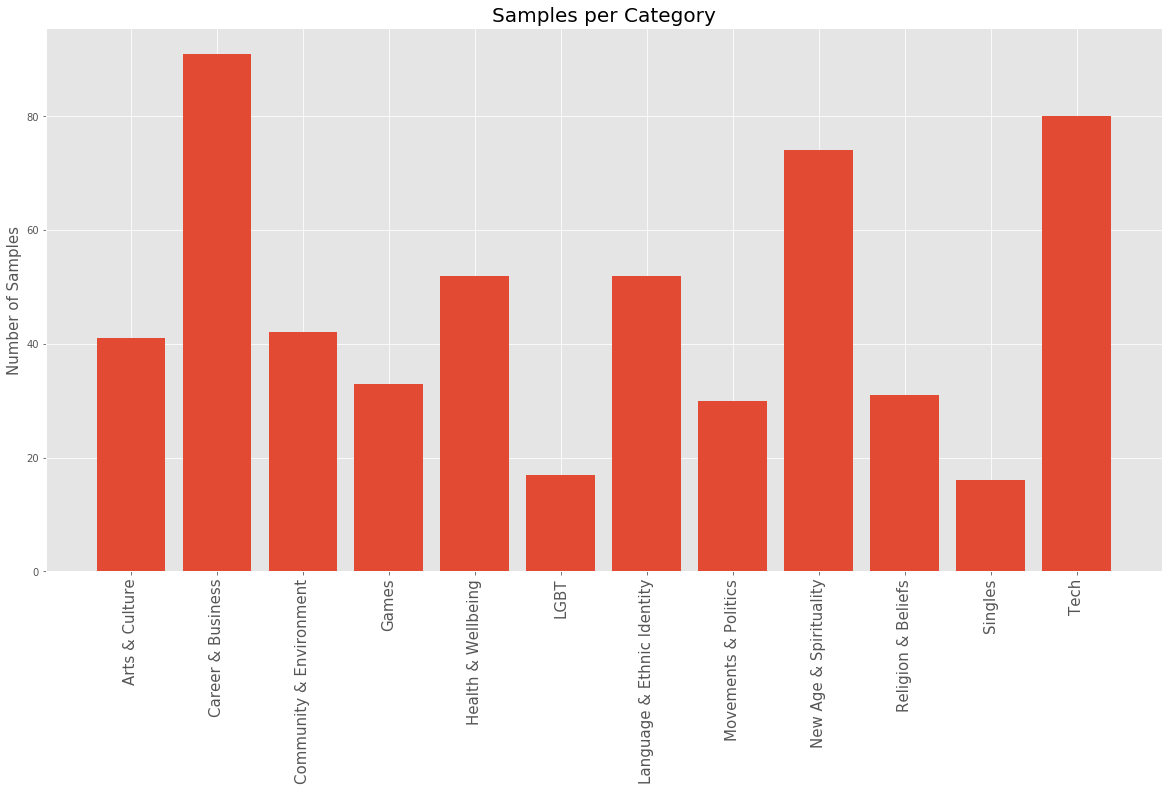

In [200]:
count = ones_removed_percent_returns.groupby('Category_Name')['Category_Name'].count()

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x = count.index, height = count)
ax.set_ylabel('Number of Samples', size = 15)
ax.set_title('Samples per Category', size = 20)
_ = ax.tick_params(axis='x', rotation=90, labelsize =15)
plt.savefig('Number_Samples_Per_category.jpg')

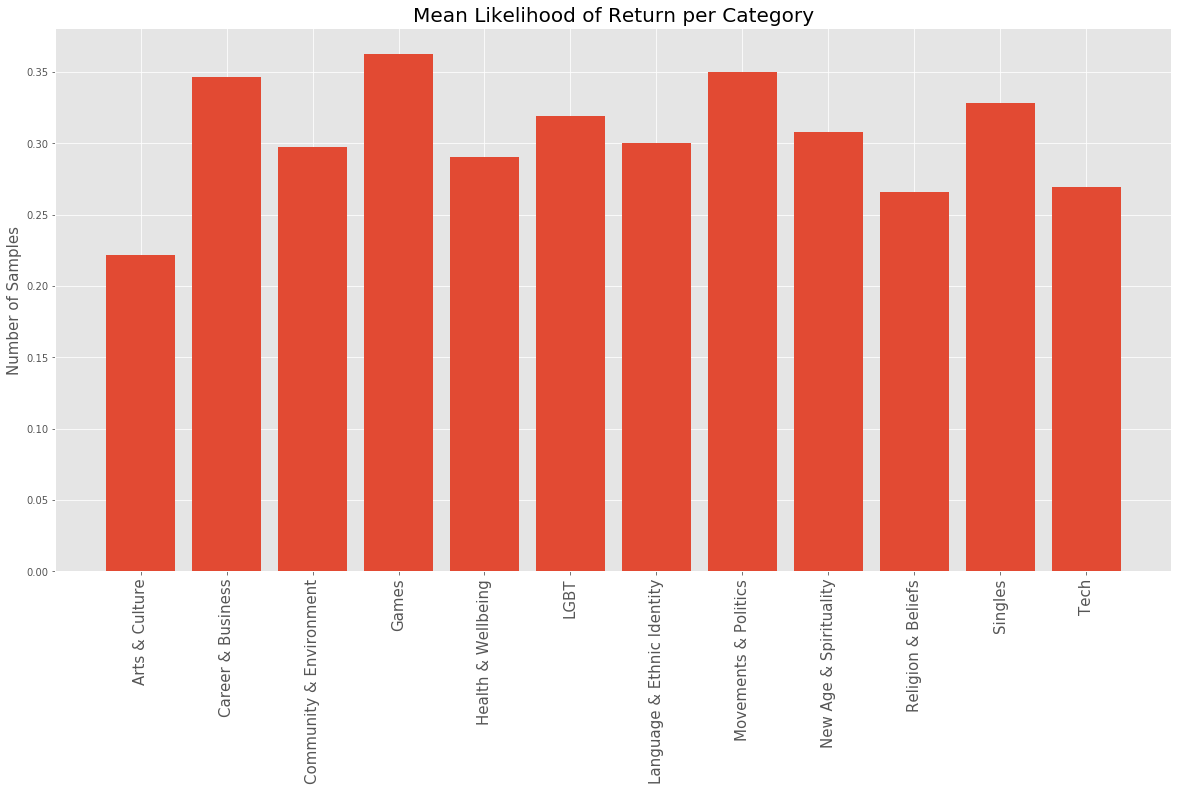

In [201]:
mean = grouped.groupby('Category_Name')['Percent_Return'].mean()

fig, ax = plt.subplots(figsize=(20,10))
ax.bar(x = mean.index, height = mean)
ax.set_ylabel('Number of Samples', size = 15)
ax.set_title('Mean Likelihood of Return per Category', size = 20)
_ = ax.tick_params(axis='x', rotation=90, labelsize =15)
plt.savefig('Means_Per_category.jpg')

# Compare distributions of two groups

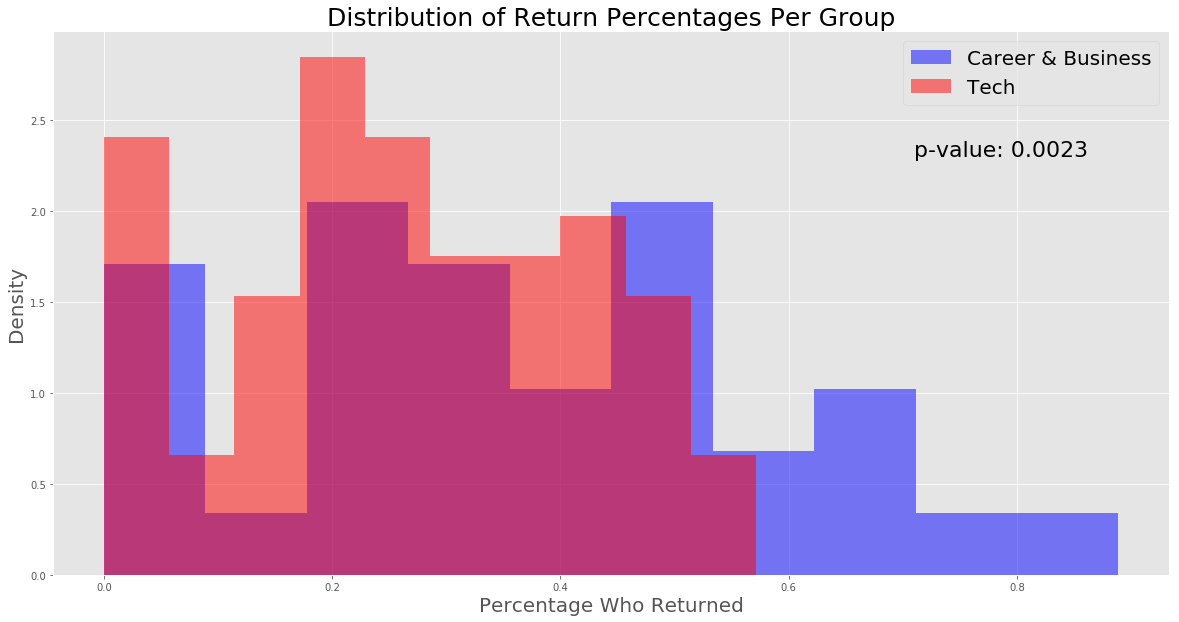

In [258]:
## career = ones_removed_percent_returns['Percent_Return'][ones_removed_percent_returns['Category_Name'] == 'Career & Business']
tech = ones_removed_percent_returns['Percent_Return'][ones_removed_percent_returns['Category_Name'] == 'Tech']
fig, ax = plt.subplots(figsize = (20,10))
ax.hist(games, bins = 10, color = 'b', alpha = 0.5, density = True, label = 'Career & Business')
ax.hist(tech, bins = 10, color = 'r', alpha = 0.5, density = True, label = 'Tech')
ax.set_ylabel('Density', size = 20)
ax.set_xlabel('Percentage Who Returned', size = 20)
ax.set_title('Distribution of Return Percentages Per Group', size = 25)
ax.tick_params(axis='both', labelsize =10)
ax.legend(loc = 'best', **{'fontsize':20})
test, p_value = scs.ttest_ind(career, tech)
_ = ax.text(x = .71, y = 2.3, s = 'p-value: {}'.format(round(p_value, 4)), fontsize = 22)
plt.savefig('Distribution_of_Career_vs_Tech.jpg')

# T-test of two groups

We can compare all 15 groups, but need to add the Bonferroni correction

We are making 105 comparisons. Thus, new p-value should be .05 / 105

In [266]:
from compare_the_group import *
categories = ones_removed_percent_returns['Category_Name'].unique()
significance_level = 0.05 / scipy.special.comb(15, 2)

print(compare_the_groups(ones_removed_percent_returns, categories, significance_level))


[['Arts & Culture', 'Career & Business'], ['Career & Business', 'Arts & Culture']]


# Variance, Sample Size, and Correlation

In [306]:
std = round(ones_removed_percent_returns['Percent_Return'].std(), 3)
mean = round(ones_removed_percent_returns['Percent_Return'].mean(), 3)
print('The mean return rate for the entire sample is {}, with a standard deviation of {}'.format(mean, std))

The mean return rate for the entire sample is 0.303, with a standard deviation of 0.183


# Does number of groups in category affect percentage_returners?

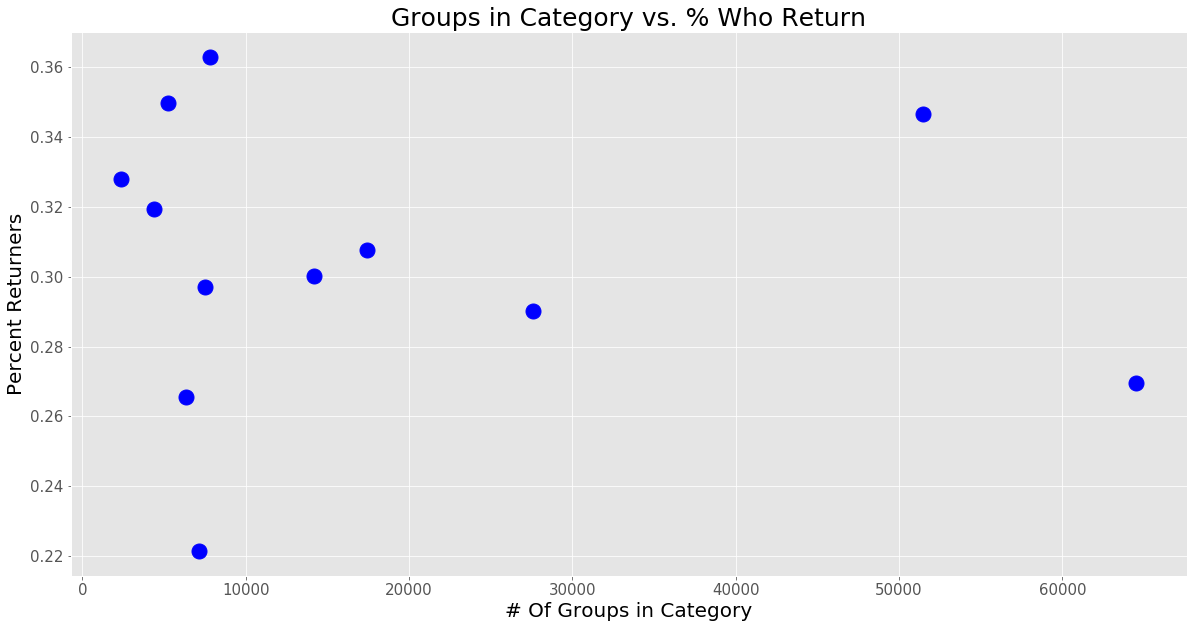

In [308]:
returns_per_group = ones_removed_percent_returns.groupby('Groups_In_Category').mean()['Percent_Return']
fig, ax = plt.subplots(figsize = (20,10))
ax.plot(returns_per_group.index, returns_per_group, 'bo', markersize= 15)
ax.set_ylabel('Percent Returners', size = 20, color = 'black')
ax.set_xlabel('# Of Groups in Category', size = 20, color = 'black')
ax.set_title('Groups in Category vs. % Who Return', size = 25)
_ = ax.tick_params(axis='both', labelsize =15)
plt.savefig('Groups_in_category_vs_Who_Return.jpg')

# Next steps

How much do retention rates change over time? That would be beautiful to visualize.

## To figure out category popularity

* Get average number of attendees / event for every category.

* Total events per category (not very helpful)

* Average events / group per category. 